In [1]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Read in the Dataset

In [3]:
path = '../kaggle_data/input/'
readings = pd.read_csv(path+'train.csv')

In [4]:
# How large is our training dataset?
print(readings.shape) 
readings.columns 

(10506, 12)


Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

In [5]:
# Individual daily trap readings are combination of date, trap, and species. Readings with > 50 mosquitos are split.
subset=readings[['NumMosquitos','Date', 'Trap', 'Species', 'WnvPresent']]
subset.groupby(['Date', 'Trap', 'Species']).sum().sort_values(['WnvPresent'], ascending=False).head()

NumMosquitos  WnvPresent
Date       Trap Species                                         
2007-08-16 T115 CULEX PIPIENS                   2532          10
2013-08-01 T900 CULEX PIPIENS/RESTUANS           984           9
2013-08-29 T900 CULEX PIPIENS                    281           8
2007-08-22 T115 CULEX PIPIENS                   1554           7
           T138 CULEX PIPIENS                   1054           6

## Outcome Variable

In [6]:
# Rename the outcome variable
readings.rename(columns={'WnvPresent':'Virus'}, inplace=True)

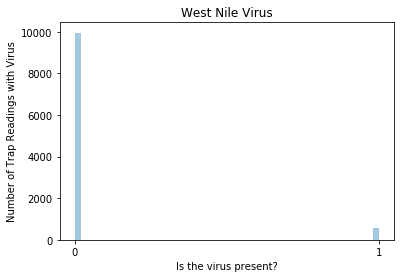

In [7]:
# It is highly imbalanced.
ax=sns.distplot(readings['Virus'], kde=None);
import matplotlib.ticker as ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set(title='West Nile Virus', ylabel='Number of Trap Readings with Virus', xlabel='Is the virus present?');

## Organize the `date` variable

In [8]:
# Let's convert date/time into something usable. 
readings['Day']=readings['Date'].str.split('-').str[-1].astype(str)
readings['Month']=readings['Date'].str.split('-').str[1].astype(str)
readings['Year']=readings['Date'].str.split('-').str[0].astype(int)
readings['MonthDay']=readings['Month'].astype(str) + readings['Day'].astype(str)
readings[['Date', 'Year', 'Month','Day', 'MonthDay']].head()

,Date,Year,Month,Day,MonthDay
0,2007-05-29,2007,05,29,0529
1,2007-05-29,2007,05,29,0529
2,2007-05-29,2007,05,29,0529
3,2007-05-29,2007,05,29,0529
4,2007-05-29,2007,05,29,0529


In [9]:
# Let's create a running count of days within the year:
readings['DayRunner']=pd.to_datetime(readings['Date']).dt.dayofyear
print(readings['DayRunner'].describe())
readings[['DayRunner', 'MonthDay', 'Month', 'Day']].head()

count    10506.000000
mean       217.941938
std         31.735797
min        148.000000
25%        196.000000
50%        217.000000
75%        241.000000
max        282.000000
Name: DayRunner, dtype: float64


,DayRunner,MonthDay,Month,Day
0,149,0529,05,29
1,149,0529,05,29
2,149,0529,05,29
3,149,0529,05,29
4,149,0529,05,29


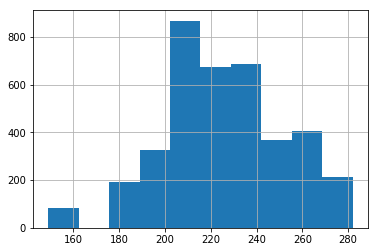

In [10]:
# Let's visualize that dayrunner variable for just one year (2007)
readings[readings['Year']==2007]['DayRunner'].hist();

In [11]:
# How many months are there? Six, ranging from May to October.
readings['Month']=readings['Month'].astype(int)
readings['Month'].value_counts().sort_index()

5       84
6     1571
7     2606
8     3751
9     2218
10     276
Name: Month, dtype: int64

In [12]:
# How many years are we talking about? Just 4 of them.
readings['Year'].value_counts()

2007    3811
2013    2392
2009    2249
2011    2054
Name: Year, dtype: int64

In [13]:
# Is the virus about the same across the four years?
x=readings['Virus'].groupby(readings['Year']).value_counts()
print(x)

Year  Virus
2007  0        3575
      1         236
2009  0        2230
      1          19
2011  0        1997
      1          57
2013  0        2153
      1         239
Name: Virus, dtype: int64


In [14]:
# Drop the variables we no longer need
readings.columns
readings=readings.drop(['Day', 'MonthDay'], axis=1)

## Species

In [15]:
## Species of Mosquito
readings['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [16]:
# Reduce this categorical variable to just 4 categories
readings['CULEX']='ALTER'
readings.loc[(readings['Species']=='CULEX PIPIENS/RESTUANS') , 'CULEX']='PIPIENS-RESTUANS'
readings.loc[(readings['Species']=='CULEX RESTUANS') , 'CULEX']='RESTUANS'
readings.loc[(readings['Species']=='CULEX PIPIENS') , 'CULEX']='PIPIENS'
readings['CULEX'].value_counts()

PIPIENS-RESTUANS    4752
RESTUANS            2740
PIPIENS             2699
ALTER                315
Name: CULEX, dtype: int64

In [17]:
# Convert those 4 categories into dummy variables for modeling later on.
dummies=pd.get_dummies(readings['CULEX'])
readings=pd.concat([readings, dummies], axis=1)

In [18]:
# Drop the unnecessary variables
readings=readings.drop(['CULEX', 'Species'], axis=1)

## Lat and Long

In [19]:
# Any missing values?
print(readings['Latitude'].isnull().sum())
print(readings['Longitude'].isnull().sum())

0
0


In [20]:
# Let's take a look at these to make sure there are no weird values or outliers.
print(readings['Latitude'].describe())
print(readings['Longitude'].describe())

count    10506.000000
mean        41.841139
std          0.112742
min         41.644612
25%         41.732984
50%         41.846283
75%         41.954690
max         42.017430
Name: Latitude, dtype: float64
count    10506.000000
mean       -87.699908
std          0.096514
min        -87.930995
25%        -87.760070
50%        -87.694991
75%        -87.627796
max        -87.531635
Name: Longitude, dtype: float64


In [21]:
# Convert lat-long into a single variable
readings['lat_long'] = list(zip(readings['Latitude'], readings['Longitude']))
readings.head(1)

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,Virus,Month,Year,DayRunner,ALTER,PIPIENS,PIPIENS-RESTUANS,RESTUANS,lat_long
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,5,2007,149,0,0,1,0,"(41.95469, -87.800991)"


In [22]:
# How many of all the lat-long combos have ever tested positive for the virus?
latlongs=readings.groupby('lat_long').mean()
print(len(latlongs)) # There are 138 unique lat/longs.
print(readings['Trap'].nunique()) # But there are only 136 unique traps. Doesn't matter: not using this var directly.

138
136


## Mapping Hot Spots where the Virus is more frequent

In [23]:
# Certain lat-longs have the virus more frequently. That's useful!
hotspots = latlongs['Virus'].rename_axis('lat-long').reset_index(name='counts')
top30=hotspots.sort_values(by='counts', ascending=False).head(30)
print(top30)
top_hots=list(top30['lat-long']) # Save this list for later use.
import pickle

with open('top_hots.pickle', 'wb') as f:
    pickle.dump(top_hots, f, protocol=0)

                    lat-long    counts
131  (41.999129, -87.795585)  0.193548
125  (41.990284, -87.797127)  0.166667
99   (41.942114, -87.776385)  0.142857
134  (42.009876, -87.807277)  0.140000
116  (41.970248, -87.787992)  0.133333
23   (41.731922, -87.677512)  0.120000
114  (41.964242, -87.757639)  0.114754
118  (41.974089, -87.824812)  0.114286
45   (41.776428, -87.627096)  0.112903
96    (41.925652, -87.63359)  0.111111
83   (41.904194, -87.756155)  0.107692
29   (41.743402, -87.731435)  0.106796
136  (42.011601, -87.811506)  0.106061
117  (41.973845, -87.805059)  0.103448
51   (41.797616, -87.797894)  0.100000
107   (41.95469, -87.800991)  0.097297
104  (41.951866, -87.725057)  0.096774
121  (41.981964, -87.812827)  0.096774
94   (41.923738, -87.785288)  0.096154
89   (41.918705, -87.752329)  0.095238
124   (41.98728, -87.666066)  0.095238
8    (41.688324, -87.676709)  0.093023
22   (41.729669, -87.582699)  0.090909
119  (41.974689, -87.890615)  0.088000
92     (41.9216, -87.6664

count    138.000000
mean       0.043366
std        0.041730
min        0.000000
25%        0.000000
50%        0.036423
75%        0.071814
max        0.193548
Name: counts, dtype: float64
5


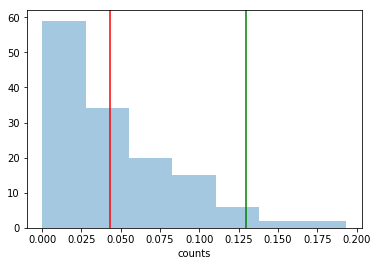

In [24]:
# What's the distribution of those? Only 5 have a virus frequency higher than 13%.
print(hotspots['counts'].describe())
print(len(hotspots[hotspots['counts']>.13]))
ax=sns.distplot(hotspots['counts'], kde=False);
plt.axvline(x=hotspots['counts'].mean(), color='red');
plt.axvline(x=.13, color='green');

## Distance from Spots with a High Virus Frequency

In [25]:
# Here's how to calculate distance in Python.
from geopy.distance import vincenty
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(vincenty(newport_ri, cleveland_oh).miles)

538.3904451566326


In [26]:
# For each trap, let's calculate its distance from the top virus hotspots
for x in range(30):
    digit=str(x)
    readings['to_hotspot'+digit]=readings['lat_long'].apply(lambda row: vincenty(row, top_hots[x]).miles)
    
    # Create an indicator if a row is less than 2 miles from one of the virus hotspots
    readings['flag_hotspot'+digit]=readings['to_hotspot'+digit].apply(lambda row: row<2).astype(int)
    
# Summarize those indicators.
hot_list=['flag_hotspot0',
          'flag_hotspot1',
          'flag_hotspot2',
          'flag_hotspot3',
          'flag_hotspot4',
          'flag_hotspot6',
          'flag_hotspot6',
          'flag_hotspot7',
          'flag_hotspot8',
          'flag_hotspot9',
          'flag_hotspot10',
          'flag_hotspot11',
          'flag_hotspot12',
          'flag_hotspot13',
          'flag_hotspot14',
          'flag_hotspot16',
          'flag_hotspot16',
          'flag_hotspot17',
          'flag_hotspot18',
          'flag_hotspot19',
          'flag_hotspot20',
          'flag_hotspot21',
          'flag_hotspot22',
          'flag_hotspot23',
          'flag_hotspot24',
          'flag_hotspot26',
          'flag_hotspot26',
          'flag_hotspot27',
          'flag_hotspot28',
          'flag_hotspot29',
         ]
readings['near_hotspot'] = readings[hot_list].sum(axis=1)
readings['near_hotspot'].describe()

count    10506.000000
mean         1.332191
std          1.588172
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: near_hotspot, dtype: float64

## Mapping Distance from Spots with a High Number of Mosquitos

In [27]:
# Are there some lat-longs with higher mosquito counts? Yes.
countspots = latlongs['NumMosquitos'].rename_axis('lat-long').reset_index(name='counts')
top30=countspots.sort_values(by='counts', ascending=False).head(30)
print(top30)
top_chomps=list(top30['lat-long']) # Save this list for later use.
with open('top_chomps.pickle', 'wb') as f:
    pickle.dump(top_chomps, f, protocol=0)

                    lat-long     counts
3    (41.673408, -87.599862)  39.977860
10   (41.702724, -87.536497)  36.000000
20   (41.726465, -87.585413)  31.643312
12   (41.704572, -87.565666)  20.718750
119  (41.974689, -87.890615)  20.514667
107   (41.95469, -87.800991)  20.054054
29   (41.743402, -87.731435)  19.553398
133  (42.008314, -87.777921)  19.194245
7    (41.686398, -87.531635)  18.933333
127  (41.992478, -87.862995)  18.462500
6    (41.682587, -87.707973)  17.517007
5    (41.680946, -87.535198)  17.072368
2    (41.662014, -87.724608)  17.060109
108  (41.957799, -87.930995)  16.621429
96    (41.925652, -87.63359)  16.111111
8    (41.688324, -87.676709)  15.255814
1    (41.659112, -87.538693)  15.169643
134  (42.009876, -87.807277)  15.160000
21   (41.728495, -87.600963)  15.115385
121  (41.981964, -87.812827)  14.935484
117  (41.973845, -87.805059)  14.724138
52   (41.798697, -87.736812)  14.601351
81    (41.89923, -87.716788)  14.301587
136  (42.011601, -87.811506)  12.833333


In [28]:
# Do the same thing for its distance from the 20 spots with highest average mosquito count.
for x in range(30):
    digit=str(x)
    readings['to_chompspot'+digit]=readings['lat_long'].apply(lambda row: vincenty(row, top_chomps[x]).miles)   

    # Create an indicator if a row is less than 2 miles from one of the high-mosquito-count chompspots
    readings['flag_chompspot'+digit]=readings['to_chompspot'+digit].apply(lambda row: row<2).astype(int)
    
# Summarize those 10 indicators.
chomp_list=['flag_chompspot0',
          'flag_chompspot1',
          'flag_chompspot2',
          'flag_chompspot3',
          'flag_chompspot4',
          'flag_chompspot6',
          'flag_chompspot6',
          'flag_chompspot7',
          'flag_chompspot8',
          'flag_chompspot9',
          'flag_chompspot10',
          'flag_chompspot11',
          'flag_chompspot12',
          'flag_chompspot13',
          'flag_chompspot14',
          'flag_chompspot16',
          'flag_chompspot16',
          'flag_chompspot17',
          'flag_chompspot18',
          'flag_chompspot19',
          'flag_chompspot20',
          'flag_chompspot21',
          'flag_chompspot22',
          'flag_chompspot23',
          'flag_chompspot24',
          'flag_chompspot26',
          'flag_chompspot26',
          'flag_chompspot27',
          'flag_chompspot28',
          'flag_chompspot29',
         ]
readings['near_chompspot'] = readings[chomp_list].sum(axis=1)
readings['near_chompspot'].describe()

count    10506.000000
mean         1.376832
std          1.265630
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: near_chompspot, dtype: float64

In [29]:
# Create a list of (nearly) all the variables we just created 
drop_list=[]
for x in range(30):
    digit=str(x)
    drop_list.append('to_hotspot'+digit)
    drop_list.append('flag_hotspot'+digit)
    drop_list.append('to_chompspot'+digit)
    drop_list.append('flag_chompspot'+digit)
# Drop them becuase they are no longer necessary.
readings=readings.drop(hot_list + chomp_list + drop_list, axis=1)

## Export to csv

In [30]:
# Drop a few columns that are just clutter now.
readings=readings.drop(['Trap', 'Address', 'Block', 'Street', 'AddressNumberAndStreet',
       'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'lat_long'], axis=1)

In [31]:
# Check the columns that are left.
readings.columns

Index(['Date', 'Virus', 'Month', 'Year', 'DayRunner', 'ALTER', 'PIPIENS',
       'PIPIENS-RESTUANS', 'RESTUANS', 'near_hotspot', 'near_chompspot'],
      dtype='object')

In [32]:
readings.head(2)

,Date,Virus,Month,Year,DayRunner,ALTER,PIPIENS,PIPIENS-RESTUANS,RESTUANS,near_hotspot,near_chompspot
0,2007-05-29,0,5,2007,149,0,0,1,0,5,3
1,2007-05-29,0,5,2007,149,0,0,0,1,5,3


In [33]:
# Save the cleaned, engineered data
dirname = '../Austin/'
readings.to_csv(dirname + 'readings.csv', index=False)